In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/mehdi/github/LSSutils')

In [4]:
from LSSutils import setup_logging

In [5]:
setup_logging('info')

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import regression

## example of eBOSS QSOs

[ 038049.29 ]   0: 12-20 10:17  NetRegression   INFO     Scale features and label
[ 038049.31 ]   0: 12-20 10:17  NetRegression   INFO     chain-0 with seed : 3391302632


........................

[ 038051.86 ]   0: 12-20 10:17  NetRegression   INFO     done in 2.5 secs


..

[ 038052.34 ]   0: 12-20 10:17  NetRegression   INFO     Test LOSS : 0.686 MAE : 0.691 MSE : 0.976
[ 038052.34 ]   0: 12-20 10:17  NetRegression   INFO     Baseline test MSE : 0.981
[ 038052.34 ]   0: 12-20 10:17  NetRegression   INFO     Variance of the test label : 0.981
[ 038052.34 ]   0: 12-20 10:17  NetRegression   INFO     Total val loss : 0.6818310407106285


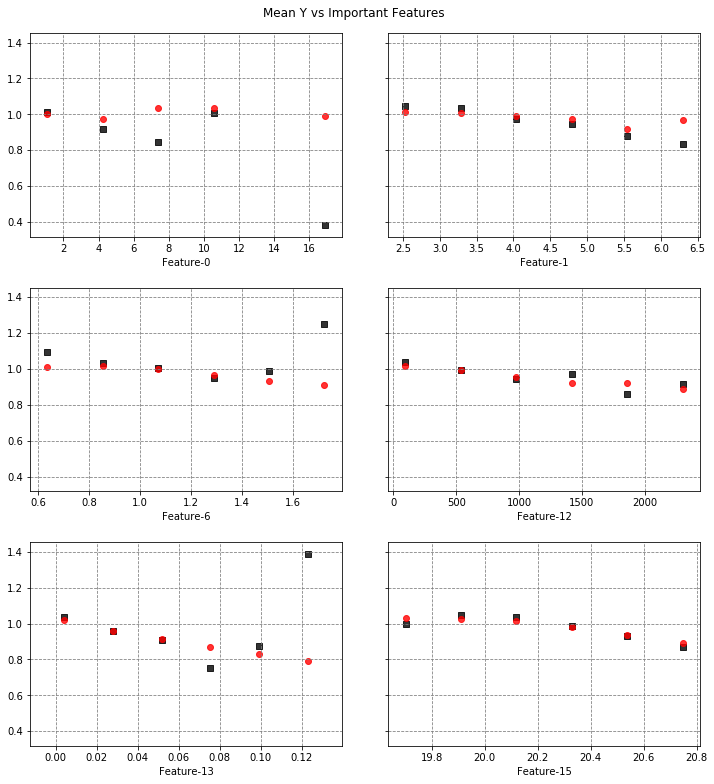

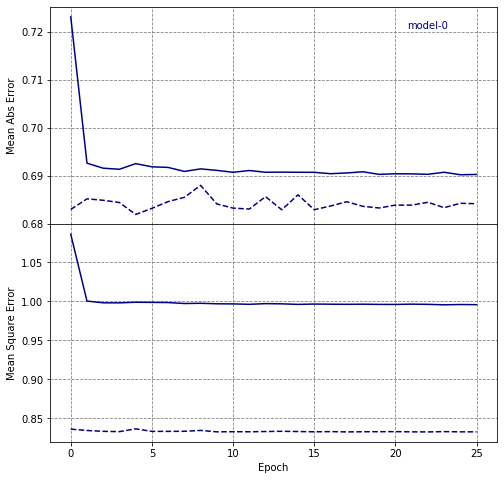

took 4.366454839706421 secs


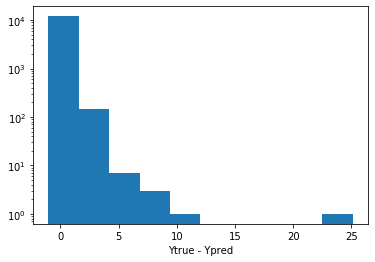

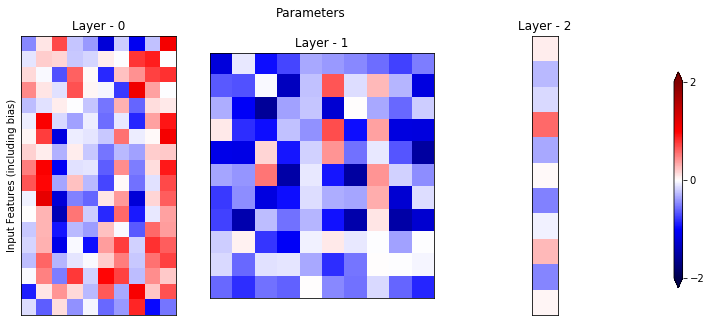

In [34]:
data  = np.load('/Users/mehdi/Downloads/trunk/qso.ngc.all.hp.256.r.npy', allow_pickle=True).item()
train = regression.Data(data['train']['fold0'])
valid = regression.Data(data['validation']['fold0'])
test  = regression.Data(data['test']['fold0'])



t_i = time.time()
Net = regression.NetRegression(train, valid, test)
#Net.fit_w_hparam_training()
Net.fit(predict=True, min_delta=1.e-8,
        batch_size=1024, units=[10, 10],
        learning_rate=0.1)
Net._descale() # descale
Net.make_plots()
t_f = time.time()
print(f'took {t_f-t_i} secs')

In [8]:
import logging

In [30]:
class FeatureElimination:
    '''
    Perform Recursive Feature Elimination
    
    
    Ex. 
    data  = np.load('/Users/mehdi/Downloads/trunk/qso.ngc.all.hp.256.r.npy', allow_pickle=True).item()
    #-- start from all indices
    train = regression.Data(data['train']['fold0'],      cachex=True)
    valid = regression.Data(data['validation']['fold0'], cachex=True)
    test  = regression.Data(data['test']['fold0'],       cachex=True)

    FE = FeatureElimination(train, valid, test)
    FE([0, 1, 2]) # only work with 3 maps
    
    '''
    logger = logging.getLogger('FeatureElimination')
    
    def __init__(self, train, validation, test):
        self.train   = train
        self.test    = test
        self.valid   = validation
        self.results = {'validmin':[], 'importance':[], 'indices':[]}
        self.kwargs  = dict(predict=False, min_delta=1.e-8,
                            batch_size=1024, units=[0],
                            learning_rate=0.1)
        
    def __call__(self, indices):

        if len(indices) == 1:
            return self.results

        vloss = []
        logger.info(f'Perform Feature Selection with {indices}')
        for index in indices:
            in_indices = indices.copy()
            in_indices.remove(index)

            #print(index_out, in_indices)
            self.train(axes=in_indices)
            self.valid(axes=in_indices)
            self.test(axes=in_indices)


            Net = regression.NetRegression(self.train, 
                                           self.valid,
                                           self.test)    
            #Net.fit_w_hparam_training()
            Net.fit(**self.kwargs)
            vloss.append(Net.total_val_loss)

        arg = np.argmin(vloss)
        self.logger.info(f'attribute index-{arg} with {vloss[arg]}')
        self.results['validmin'].append(vloss)
        self.results['indices'].append(indices.copy())
        self.results['importance'].append(indices.pop(arg))
        
        self(indices)

In [31]:
#-- start from all indices
train = regression.Data(data['train']['fold0'],      cachex=True)
valid = regression.Data(data['validation']['fold0'], cachex=True)
test  = regression.Data(data['test']['fold0'],       cachex=True)

FE = FeatureElimination(train, valid, test)

In [32]:
FE([0, 1 ,2])

[ 037785.27 ]   0: 12-20 10:13  FeatureElimination INFO     Perform Feature Selection with [0, 1, 2]
[ 037785.27 ]   0: 12-20 10:13  NetRegression   INFO     Scale features and label
[ 037785.28 ]   0: 12-20 10:13  NetRegression   INFO     chain-0 with seed : 3391302632


..................

[ 037787.27 ]   0: 12-20 10:13  NetRegression   INFO     done in 1.9 secs
[ 037787.27 ]   0: 12-20 10:13  NetRegression   INFO     Total val loss : 0.6844106853941896
[ 037787.27 ]   0: 12-20 10:13  NetRegression   INFO     Scale features and label
[ 037787.28 ]   0: 12-20 10:13  NetRegression   INFO     chain-0 with seed : 3391302632


.......................

[ 037789.06 ]   0: 12-20 10:13  NetRegression   INFO     done in 1.7 secs
[ 037789.06 ]   0: 12-20 10:13  NetRegression   INFO     Total val loss : 0.6846293662072014
[ 037789.06 ]   0: 12-20 10:13  NetRegression   INFO     Scale features and label
[ 037789.07 ]   0: 12-20 10:13  NetRegression   INFO     chain-0 with seed : 3391302632


.....................

[ 037790.72 ]   0: 12-20 10:13  NetRegression   INFO     done in 1.6 secs
[ 037790.72 ]   0: 12-20 10:13  NetRegression   INFO     Total val loss : 0.6844244615164848
[ 037790.72 ]   0: 12-20 10:13  FeatureElimination INFO     attribute index-0 with 0.6844106853941896
[ 037790.72 ]   0: 12-20 10:13  FeatureElimination INFO     Perform Feature Selection with [1, 2]
[ 037790.72 ]   0: 12-20 10:13  NetRegression   INFO     Scale features and label
[ 037790.73 ]   0: 12-20 10:13  NetRegression   INFO     chain-0 with seed : 3391302632


.....................

[ 037792.29 ]   0: 12-20 10:13  NetRegression   INFO     done in 1.5 secs
[ 037792.30 ]   0: 12-20 10:13  NetRegression   INFO     Total val loss : 0.6846183372054921
[ 037792.30 ]   0: 12-20 10:13  NetRegression   INFO     Scale features and label
[ 037792.30 ]   0: 12-20 10:13  NetRegression   INFO     chain-0 with seed : 3391302632


..............................

[ 037794.91 ]   0: 12-20 10:13  NetRegression   INFO     done in 2.5 secs


.....

[ 037794.91 ]   0: 12-20 10:13  NetRegression   INFO     Total val loss : 0.6844144350226419
[ 037794.92 ]   0: 12-20 10:13  FeatureElimination INFO     attribute index-1 with 0.6844144350226419


In [25]:
#-- start from all indices
train = regression.Data(data['train']['fold0'],      cachex=True)
valid = regression.Data(data['validation']['fold0'], cachex=True)
test  = regression.Data(data['test']['fold0'],       cachex=True)


logger  = logging.getLogger('FeatureElimination')
indices = [i for i in range(3)]
results = {'validmin':[], 'importance':[], 'indices':[]}
while len(indices) > 1:    
    vloss = []
    logger.info(f'Perform Feature Selection with {indices}')
    for index in indices:
        in_indices = indices.copy()
        in_indices.remove(index)

        #print(index_out, in_indices)
        train(axes=in_indices)
        valid(axes=in_indices)
        test(axes=in_indices)


        Net = regression.NetRegression(train, valid, test)    
        #Net.fit_w_hparam_training()
        Net.fit(predict=False, min_delta=1.e-8,
                batch_size=1024, units=[0],
                learning_rate=0.1)
        vloss.append(Net.total_val_loss)

    arg = np.argmin(vloss)
    logger.info(f'attribute index-{arg} with {vloss[arg]}')
    results['validmin'].append(vloss)
    results['indices'].append(indices.copy())
    results['importance'].append(indices.pop(arg))



    
    #print(in_indices)
    
    
# train = regression.Data(data['train']['fold0'])
# valid = regression.Data(data['validation']['fold0'])
# test  = regression.Data(data['test']['fold0'])
# Net = regression.NetRegression(train, valid, test)
# #Net.fit_w_hparam_training()
# Net.fit(predict=True, min_delta=1.e-8,
#         batch_size=1024, units=[10, 10],
#         learning_rate=0.1)

[ 037389.72 ]   0: 12-20 10:06  FeatureElimination INFO     Perform Feature Selection with [0, 1, 2]
[ 037389.72 ]   0: 12-20 10:06  NetRegression   INFO     Scale features and label
[ 037389.74 ]   0: 12-20 10:06  NetRegression   INFO     chain-0 with seed : 3391302632


....................

[ 037391.52 ]   0: 12-20 10:06  NetRegression   INFO     done in 1.7 secs
[ 037391.52 ]   0: 12-20 10:06  NetRegression   INFO     Total val loss : 0.6844106853941896
[ 037391.52 ]   0: 12-20 10:06  NetRegression   INFO     Scale features and label
[ 037391.53 ]   0: 12-20 10:06  NetRegression   INFO     chain-0 with seed : 3391302632


.....................

[ 037393.38 ]   0: 12-20 10:06  NetRegression   INFO     done in 1.8 secs
[ 037393.38 ]   0: 12-20 10:06  NetRegression   INFO     Total val loss : 0.6846293662072014
[ 037393.39 ]   0: 12-20 10:06  NetRegression   INFO     Scale features and label
[ 037393.39 ]   0: 12-20 10:06  NetRegression   INFO     chain-0 with seed : 3391302632


.....................

[ 037395.04 ]   0: 12-20 10:06  NetRegression   INFO     done in 1.6 secs
[ 037395.04 ]   0: 12-20 10:06  NetRegression   INFO     Total val loss : 0.6844244615164848
[ 037395.04 ]   0: 12-20 10:06  FeatureElimination INFO     attribute index-0 with 0.6844106853941896
[ 037395.04 ]   0: 12-20 10:06  FeatureElimination INFO     Perform Feature Selection with [1, 2]
[ 037395.04 ]   0: 12-20 10:06  NetRegression   INFO     Scale features and label
[ 037395.05 ]   0: 12-20 10:06  NetRegression   INFO     chain-0 with seed : 3391302632


....................

[ 037396.89 ]   0: 12-20 10:06  NetRegression   INFO     done in 1.8 secs
[ 037396.89 ]   0: 12-20 10:06  NetRegression   INFO     Total val loss : 0.6846183372054921
[ 037396.90 ]   0: 12-20 10:06  NetRegression   INFO     Scale features and label
[ 037396.90 ]   0: 12-20 10:06  NetRegression   INFO     chain-0 with seed : 3391302632


...................................

[ 037399.36 ]   0: 12-20 10:06  NetRegression   INFO     done in 2.4 secs
[ 037399.36 ]   0: 12-20 10:06  NetRegression   INFO     Total val loss : 0.6844144350226419
[ 037399.36 ]   0: 12-20 10:06  FeatureElimination INFO     attribute index-1 with 0.6844144350226419


.

In [33]:
FE.results

{'validmin': [[0.6844106853941896, 0.6846293662072014, 0.6844244615164848],
  [0.6846183372054921, 0.6844144350226419]],
 'importance': [0, 2],
 'indices': [[0, 1, 2], [1, 2]]}

In [26]:
results

{'validmin': [[0.6844106853941896, 0.6846293662072014, 0.6844244615164848],
  [0.6846183372054921, 0.6844144350226419]],
 'importance': [0, 2],
 'indices': [[0, 1, 2], [1, 2]]}

## example of Sin function

[ 014826.11 ] : 11-29 20:40  NetRegression   INFO     Scale features and label
[ 014826.19 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


.......................................................................................................................

[ 014828.79 ] : 11-29 20:40  NetRegression   INFO     done in 2.4 secs
[ 014828.79 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.004893622826784849
[ 014828.79 ] : 11-29 20:40  NetRegression   INFO     start hyperparameter training with {'learning_rate': 0.01, 'batch_size': 256, 'nepochs': 500, 'nchain': 1, 'units': [20, 20], 'scale': 0.0, 'patience': 10, 'min_delta': 1e-05, 'global_seed': 123567, 'model_dir': 'model/', 'save_model': False}
[ 014828.80 ] : 11-29 20:40  NetRegression   INFO     training with units : [40]
[ 014828.80 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


..................

[ 014829.53 ] : 11-29 20:40  NetRegression   INFO     done in 0.6 secs
[ 014829.54 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.3813011050224304
[ 014829.54 ] : 11-29 20:40  NetRegression   INFO     training with units : [20, 20]
[ 014829.54 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


............................................................................................................................................................

[ 014831.09 ] : 11-29 20:40  NetRegression   INFO     done in 1.4 secs
[ 014831.09 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.004893622826784849
[ 014831.09 ] : 11-29 20:40  NetRegression   INFO     training with units : [20, 10, 10]
[ 014831.10 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


.........................................................................................................................................................

[ 014833.55 ] : 11-29 20:40  NetRegression   INFO     done in 2.4 secs
[ 014833.56 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.005422091577202082
[ 014833.56 ] : 11-29 20:40  NetRegression   INFO     training with units : [10, 10, 10, 10]
[ 014833.57 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


...............................................................................

[ 014836.62 ] : 11-29 20:40  NetRegression   INFO     done in 2.8 secs
[ 014836.62 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.05274239182472229
[ 014836.63 ] : 11-29 20:40  NetRegression   INFO     select units : [20, 20] as the best
[ 014836.63 ] : 11-29 20:40  NetRegression   INFO     training with scale : 0.0001
[ 014836.64 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


..................................................................................................................................

[ 014838.32 ] : 11-29 20:40  NetRegression   INFO     done in 1.5 secs
[ 014838.32 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.01415691152215004
[ 014838.32 ] : 11-29 20:40  NetRegression   INFO     training with scale : 0.001
[ 014838.33 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


.................................................................................................................................................................................................................................................................................................................................................

[ 014841.19 ] : 11-29 20:40  NetRegression   INFO     done in 2.7 secs
[ 014841.19 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.03592398762702942
[ 014841.19 ] : 11-29 20:40  NetRegression   INFO     training with scale : 0.01
[ 014841.20 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


........................................................................................................................................................................................................................................

[ 014843.40 ] : 11-29 20:40  NetRegression   INFO     done in 2.1 secs
[ 014843.40 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.13050080835819244
[ 014843.40 ] : 11-29 20:40  NetRegression   INFO     training with scale : 0.1
[ 014843.41 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


.............................................................................................................................................................

[ 014845.16 ] : 11-29 20:40  NetRegression   INFO     done in 1.6 secs
[ 014845.17 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.5443853735923767
[ 014845.17 ] : 11-29 20:40  NetRegression   INFO     training with scale : 1.0
[ 014845.17 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


........................................................................................................................................................................................

[ 014847.27 ] : 11-29 20:40  NetRegression   INFO     done in 2.0 secs
[ 014847.27 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.900741696357727
[ 014847.27 ] : 11-29 20:40  NetRegression   INFO     training with scale : 10
[ 014847.27 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


.....................................................................................................................................................................................................

[ 014849.44 ] : 11-29 20:40  NetRegression   INFO     done in 1.9 secs
[ 014849.44 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.9020035266876221
[ 014849.44 ] : 11-29 20:40  NetRegression   INFO     training with scale : 100


.....................................

[ 014849.45 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


......................................................................................................................................................................................................................................................................

[ 014852.08 ] : 11-29 20:40  NetRegression   INFO     done in 2.5 secs
[ 014852.08 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.8986510038375854
[ 014852.08 ] : 11-29 20:40  NetRegression   INFO     training with scale : 1000
[ 014852.09 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


..............................................................................................................................................................................................................................................................................

[ 014854.61 ] : 11-29 20:40  NetRegression   INFO     done in 2.4 secs
[ 014854.61 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.9005280137062073
[ 014854.61 ] : 11-29 20:40  NetRegression   INFO     select scale : 0.0 as the best
[ 014854.61 ] : 11-29 20:40  NetRegression   INFO     training with batch_size : 128
[ 014854.62 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


.............................................................................

[ 014855.88 ] : 11-29 20:40  NetRegression   INFO     done in 1.2 secs
[ 014855.88 ] : 11-29 20:40  NetRegression   INFO     Total val loss : 0.004870792385190725
[ 014855.88 ] : 11-29 20:40  NetRegression   INFO     training with batch_size : 256


.................................

[ 014855.89 ] : 11-29 20:40  NetRegression   INFO     chain-0 with seed : 3391302632


.................................................................................................................

[ 014857.41 ] : 11-29 20:41  NetRegression   INFO     done in 1.4 secs
[ 014857.41 ] : 11-29 20:41  NetRegression   INFO     Total val loss : 0.004893622826784849
[ 014857.41 ] : 11-29 20:41  NetRegression   INFO     training with batch_size : 512
[ 014857.42 ] : 11-29 20:41  NetRegression   INFO     chain-0 with seed : 3391302632


........................

[ 014858.02 ] : 11-29 20:41  NetRegression   INFO     done in 0.5 secs
[ 014858.02 ] : 11-29 20:41  NetRegression   INFO     Total val loss : 0.41710343956947327
[ 014858.02 ] : 11-29 20:41  NetRegression   INFO     training with batch_size : 1024
[ 014858.03 ] : 11-29 20:41  NetRegression   INFO     chain-0 with seed : 3391302632


..............

[ 014858.81 ] : 11-29 20:41  NetRegression   INFO     done in 0.7 secs
[ 014858.81 ] : 11-29 20:41  NetRegression   INFO     Total val loss : 0.41710343956947327
[ 014858.81 ] : 11-29 20:41  NetRegression   INFO     training with batch_size : 2048
[ 014858.81 ] : 11-29 20:41  NetRegression   INFO     chain-0 with seed : 3391302632


..............

[ 014859.43 ] : 11-29 20:41  NetRegression   INFO     done in 0.5 secs
[ 014859.43 ] : 11-29 20:41  NetRegression   INFO     Total val loss : 0.41710343956947327
[ 014859.43 ] : 11-29 20:41  NetRegression   INFO     training with batch_size : 4096
[ 014859.44 ] : 11-29 20:41  NetRegression   INFO     chain-0 with seed : 3391302632


..............

[ 014860.54 ] : 11-29 20:41  NetRegression   INFO     done in 1.0 secs
[ 014860.54 ] : 11-29 20:41  NetRegression   INFO     Total val loss : 0.41710343956947327
[ 014860.54 ] : 11-29 20:41  NetRegression   INFO     select batch_size : 128 as the best
[ 014860.54 ] : 11-29 20:41  NetRegression   INFO     final set of hyperparameters : {'learning_rate': 0.01, 'batch_size': 128, 'nepochs': 500, 'nchain': 1, 'units': [20, 20], 'scale': 0.0, 'patience': 10, 'min_delta': 1e-05, 'global_seed': 123567, 'model_dir': 'model/', 'save_model': False}
[ 014860.55 ] : 11-29 20:41  NetRegression   INFO     final training with {'learning_rate': 0.01, 'batch_size': 128, 'nepochs': 500, 'nchain': 5, 'units': [20, 20], 'scale': 0.0, 'patience': 10, 'min_delta': 1e-05, 'global_seed': 123567, 'model_dir': 'model/', 'save_model': False, 'predict': True}
[ 014860.55 ] : 11-29 20:41  NetRegression   INFO     chain-0 with seed : 3391302632


.......................................................................................................................................

[ 014862.80 ] : 11-29 20:41  NetRegression   INFO     done in 2.0 secs


....

[ 014863.00 ] : 11-29 20:41  NetRegression   INFO     Test LOSS : 0.009 MAE : 0.060 MSE : 0.009
[ 014863.01 ] : 11-29 20:41  NetRegression   INFO     Baseline test MSE : 1.158
[ 014863.01 ] : 11-29 20:41  NetRegression   INFO     Variance of the test label : 1.154
[ 014863.01 ] : 11-29 20:41  NetRegression   INFO     chain-1 with seed : 2688729627


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 014866.90 ] : 11-29 20:41  NetRegression   INFO     done in 3.7 secs
[ 014867.03 ] : 11-29 20:41  NetRegression   INFO     Test LOSS : 0.287 MAE : 0.447 MSE : 0.287
[ 014867.03 ] : 11-29 20:41  NetRegression   INFO     Baseline test MSE : 1.158
[ 014867.03 ] : 11-29 20:41  NetRegression   INFO     Variance of the test label : 1.154
[ 014867.03 ] : 11-29 20:41  NetRegression   INFO     chain-2 with seed : 1716448871


............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 014873.23 ] : 11-29 20:41  NetRegression   INFO     done in 6.1 secs


.............................

[ 014873.36 ] : 11-29 20:41  NetRegression   INFO     Test LOSS : 0.160 MAE : 0.317 MSE : 0.160
[ 014873.36 ] : 11-29 20:41  NetRegression   INFO     Baseline test MSE : 1.158
[ 014873.36 ] : 11-29 20:41  NetRegression   INFO     Variance of the test label : 1.154
[ 014873.36 ] : 11-29 20:41  NetRegression   INFO     chain-3 with seed : 3960051926


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 014877.06 ] : 11-29 20:41  NetRegression   INFO     done in 3.6 secs


...............................

[ 014877.19 ] : 11-29 20:41  NetRegression   INFO     Test LOSS : 0.194 MAE : 0.348 MSE : 0.194
[ 014877.19 ] : 11-29 20:41  NetRegression   INFO     Baseline test MSE : 1.158
[ 014877.19 ] : 11-29 20:41  NetRegression   INFO     Variance of the test label : 1.154
[ 014877.19 ] : 11-29 20:41  NetRegression   INFO     chain-4 with seed : 1829331237


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[ 014881.07 ] : 11-29 20:41  NetRegression   INFO     done in 3.8 secs


................................

[ 014881.20 ] : 11-29 20:41  NetRegression   INFO     Test LOSS : 0.192 MAE : 0.345 MSE : 0.192
[ 014881.20 ] : 11-29 20:41  NetRegression   INFO     Baseline test MSE : 1.158
[ 014881.20 ] : 11-29 20:41  NetRegression   INFO     Variance of the test label : 1.154
[ 014881.20 ] : 11-29 20:41  NetRegression   INFO     Total val loss : 0.8229736681096256


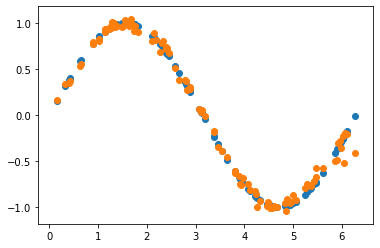

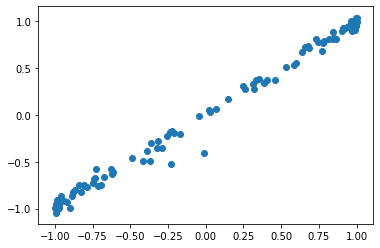

took 55.09750986099243 secs


In [12]:
import sys
sys.path.append('/Users/mehdi/github/LSSutils')
from LSSutils.utils import split2Kfolds 


def TABLE(): # create mock
    # create data
    n = 512
    np.random.seed(1234567)
    x = np.linspace(0., 2.*np.pi, n)
    z = np.random.uniform(0, 2*np.pi, size=n)
    np.random.shuffle(x) # inplace 
    y = np.sin(x) #+ 0.2*z
    #x = x[:, np.newaxis]
    x = np.column_stack([x, z])

    n,m = x.shape
    d = np.empty(n, dtype=[('label', 'f8'), 
                            ('features', ('f8', m)),
                            ('fracgood', 'f8'),
                            ('hpind', 'i8')])
    d['label'] = y
    if m==1:
        d['features']=x.squeeze()
    else:
        d['features']=x

    d['hpind']=1.
    d['fracgood']=1.0
    return d



# make table [label, features, fracgood, hpind]
Table  = TABLE()          # make table
Data5f = split2Kfolds(Table, k=5)     # split

# take one fold for example
fold   = 'fold0'
train  = regression.Data(Data5f['train'][fold])
test   = regression.Data(Data5f['test'][fold])
valid  = regression.Data(Data5f['validation'][fold])



t_i = time.time()
Net = regression.NetRegression(train, valid, test)
Net.fit_w_hparam_training()
# Net.fit(predict=True,
#         batch_size=256, units=[3, 100, 100], 
#         min_delta=1.e-12)
Net._descale() # descale
#Net.make_plots()
t_f = time.time()

plt.figure()
plt.scatter(test.x[:,0], test.y)
plt.scatter(test.x[:,0], Net.ypreds[0]);plt.show()
plt.scatter(test.y, Net.ypreds[0]);plt.show()
print(f'took {t_f-t_i} secs')

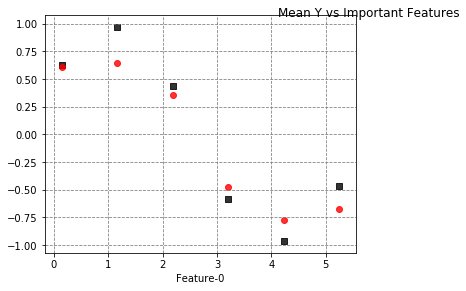

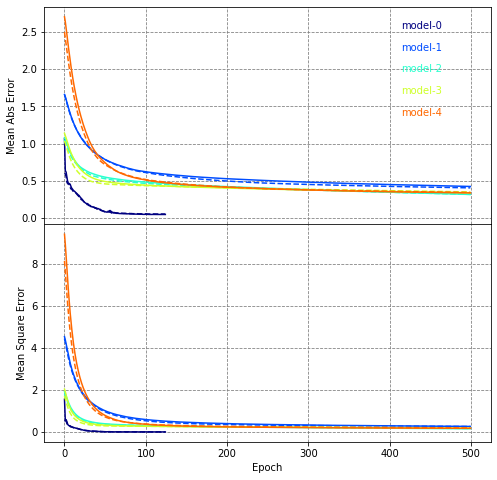

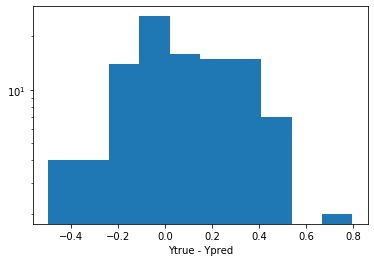

In [13]:
Net.make_plots()

In [14]:
Net.attrs

{'learning_rate': 0.01,
 'batch_size': 128,
 'nepochs': 500,
 'nchain': 5,
 'units': [20, 20],
 'scale': 0.0,
 'patience': 10,
 'min_delta': 1e-05,
 'global_seed': 123567,
 'model_dir': 'model/',
 'save_model': False}

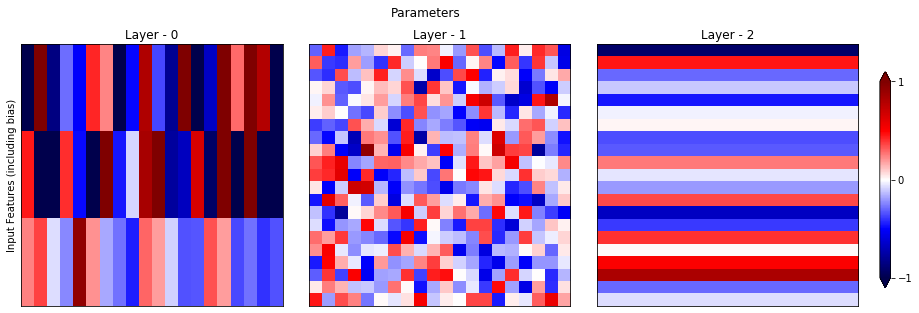

In [16]:
weights = Net.history[0].model.get_weights()
ncols   = len(weights) //2
fig, ax = plt.subplots(ncols=ncols, figsize=(5*ncols, 5))
fig.subplots_adjust(wspace=0.1, top=0.9)
fig.suptitle('Parameters')

for j in range(ncols):
    ax[j].set_title(f'Layer - {j}')
    extend = [0, 20, 0, 20]
    map1 = ax[j].imshow(np.row_stack([weights[2*j], weights[2*j+1]]), 
                 cmap=plt.cm.seismic, vmin=-1., vmax=1., extent=extend)
    #plt.setp(ax[j].get_xticklabels(), visible=False)
    #plt.setp(ax[j].get_yticklabels(), visible=False)
    ax[j].tick_params(
            axis='both',        # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            right=False,
            left=False,
            labelbottom=False) # labels along the bottom edge are off
    ax[j].set(yticks=[], xticks=[])        
    if j==0:ax[j].set(ylabel='Input Features (including bias)')
        
cax = plt.axes([.92, 0.2, 0.01, 0.6])
#cax = plt.axes([.25, 0.05, 0.5, 0.05]) ## goes w orientation='horizontal'
## colorbar label='parameters'
fig.colorbar(map1, cax=cax, 
             shrink=0.7, ticks=[-1, 0, 1], 
             extend='both')

        #.show()
#plt.colorbar()

In [37]:
# #             #
# #             # placeholders for the input errorbar and label
# #             y_  = tf.compat.v1.placeholder(tf.float32, [None, nclass])
# #             w   = tf.compat.v1.placeholder(tf.float32, [None, nclass])

# #             #
# #             # objective function
# #             mse = tf.compat.v1.losses.mean_squared_error(y_, y, weights=w)
# #             l2_loss = tf.compat.v1.losses.get_regularization_loss()
# #             mse_w_l2 = mse + l2_loss
# #             #
# #             # see https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer
# #             global_step = tf.Variable(0, name='global_step', trainable=False)
# #             optimizer   = tf.compat.v1.train.AdamOptimizer(learning_rate)
# #             train_step  = optimizer.minimize(mse_w_l2, global_step=global_step)            
# #             #print('chain ',ii)
# #             mse_min = 10000000.
# #             last_improvement = 0
# #             mse_list = []
# #             # 
# #             # initialize the NN
# #             #config = tf.ConfigProto()
# #             #config.intra_op_parallelism_threads = 1
# #             #config.inter_op_parallelism_threads = 1
# #             #sess = tf.InteractiveSession(config=config)
# #             sess = tf.compat.v1.InteractiveSession()
# #             tf.compat.v1.global_variables_initializer().run() 
# #             if verbose:iepoch = tqdm.tqdm(total=nepoch+1, desc='Epoch', position=1)
# #             for i in range(nepoch+1): # loop on training epochs
# #                 #
# #                 # save train & test MSE at each epoch
# #                 train_loss = mse.eval(feed_dict={x:train.X, y_:train.Y, w:train.W}) # June 7th 2:20pm - change self.train.X to train.X
# #                 valid_loss = mse.eval(feed_dict={x:valid.X, y_:valid.Y, w:valid.W})                                
# #                 #test_loss = mse.eval(feed_dict={x:test.X, y_:test.Y, w:test.W}) # to evaluate test MSE
# #                 mse_list.append([i, train_loss, valid_loss])
# #                 #mse_list.append([i, train_loss, valid_loss, test_loss])  # to save test MSE
# #                 #
# #                 #  Early Stopping
# #                 if (np.abs(valid_loss/mse_min -1.0) > tol) and (valid_loss < mse_min):
# #                     mse_min = valid_loss
# #                     last_improvement = 0
# #                 else:
# #                     last_improvement += 1
                
# #                 if last_improvement > patience:
# #                     #print("No improvement found during the {} last iterations at {}, stopping optimization!!".format(patience, i))
# #                     #print("stopping at {}".format(i))
# #                     break # stop training by early stopping
# #                 for k in range(nep): # loop on training unpdates
# #                     ji = k*batchsize
# #                     jj = np.minimum((k+1)*batchsize, train_size)                    
# #                     batch_xs, batch_ys, batch_ws = train.X[ji:jj], train.Y[ji:jj], train.W[ji:jj]   # use up to the last element
# #                     # train NN at each update
# #                     sess.run(train_step, feed_dict={x: batch_xs, y_:batch_ys, w:batch_ws})
# #                 if verbose:iepoch.update(1)
# #             #
            
# #             # save the final test MSE and prediction for each chain 
# #             y_mse, y_pred  = sess.run((mse,y),feed_dict={x: test.X, y_: test.Y, w:test.W})
# #             self.chain_y.append([ii, y_pred])
# #             self.epoch_MSEs.append([ii, y_mse, np.array(mse_list)])
# #             sess.close()
# #             tf.compat.v1.reset_default_graph()
# #             if verbose:ichain.update(1)
# #         # baseline model is the average of training label
# #         # baseline mse
# #         baselineY  = np.mean(train.Y)
# #         assert np.abs(baselineY) < 1.e-6, 'check normalization!'
# #         baseline_testmse  = np.mean(test.W  * test.Y**2)
# #         baseline_validmse = np.mean(valid.W * valid.Y**2)
# #         baseline_trainmse = np.mean(train.W * train.Y**2)
# #         #    
# #         self.optionsdic = {}
# #         self.optionsdic['baselineMSE']   = (baseline_trainmse, baseline_validmse, baseline_testmse)
# #         self.optionsdic['learning_rate'] = learning_rate
# #         self.optionsdic['batchsize']     = batchsize
# #         self.optionsdic['nepoch']        = nepoch
# #         self.optionsdic['nchain']        = nchain
# #         self.optionsdic['Units']         = Units
# #         self.optionsdic['scale']         = scale
# #         self.optionsdic['stats']         = {'xstat':self.Xstat, 'ystat':self.Ystat}

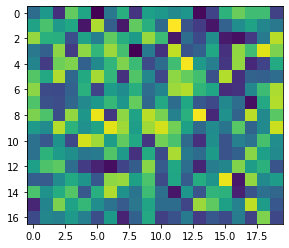

In [20]:
plt.imshow(NN.history[2].model.get_weights()[0])

In [ ]:
import tensorflow as tf                    # NN stuff
import tqdm
import numpy as np                         # numerical python 
import os

# imac branch
class preprocess(object):
    def __init__(self, datai, axfit=None):
        np.random.seed(12345)
        data   = datai.copy()      # copy input data
        np.random.shuffle(data)    # shuffle input data
        self.X = data['features']
        self.Y = data['label'][:,np.newaxis]
        self.P = data['hpind']
        self.W = data['fracgood'][:, np.newaxis]#**2
        if len(self.X.shape) == 1:
            self.X = self.X[:,np.newaxis]
        if axfit is not None:
            self.X = self.X[:, axfit]
            
        #self.Xs = None
        #self.Ys = None
        
    
class Netregression(object):
    """
        class for a general regression
    """
    def __init__(self, train, valid, test, axfit=None):
        # data (Traind, Testd) should have following attrs,
        #
        # features i.e.  X
        # label    i.e. Y = f(X) + noise ?
        # hpix     i.e. healpix indices to keep track of data
        # fracgood i.e. weight associated to each datapoint eg. pixel
        #
        # train
        self.train = preprocess(train, axfit)
        # test
        self.test  = preprocess(test,  axfit)
        # validation
        self.valid = preprocess(valid, axfit)
        
        #
        # one feature or more
        self.nfeatures = self.train.X.shape[1]
        
        
    def train_evaluate(self, learning_rate=0.001,
                       batchsize=100, nepoch=10, nchain=5,
                      Units=[10,10], tol=1.e-5, scale=0.0,
                       actfunc=tf.nn.relu, patience=10, verbose=False):
        #
        #from tensorflow.python.framework import ops

        nfeature = self.nfeatures
        #print('nfeature : ', nfeature)
        nclass   = 1            # for classification, you will have to change this
        #
        
        #
        #
        train = self.train
        valid = self.valid
        test  = self.test
        
        train_size = train.X.shape[0]
        #
        # using training label/feature mean and std
        # to normalize training/testing label/feature
        meanX      = np.mean(train.X, axis=0)
        stdX       = np.std(train.X, axis=0)
        meanY      = np.mean(train.Y, axis=0)
        stdY       = np.std(train.Y, axis=0)
        #
        # convert 0 stds to 1.0s
        assert np.all(stdX != 0.0)
        assert (stdY != 0.0)        
        #stdX[stdX==0.0] = 1.0

        
        self.Xstat = (meanX, stdX)
        self.Ystat = (meanY, stdY)
        
        train.X = (train.X - meanX) / stdX
        train.Y = (train.Y - meanY) / stdY
        test.X  = (test.X - meanX) / stdX
        test.Y  = (test.Y - meanY) / stdY
        valid.X = (valid.X - meanX) / stdX
        valid.Y = (valid.Y - meanY) / stdY
        #
        # compute the number of training updates
        if np.mod(train_size, batchsize) == 0:
            nep = (train_size // batchsize)
        else:
            nep = (train_size // batchsize) + 1
        #
        # initialize empty lists to store MSE 
        # and prediction at each training epoch for each chain
        self.epoch_MSEs = []
        self.chain_y     = []
        global_seed = 12345
        np.random.seed(global_seed)
        seeds = np.random.randint(0, 4294967295, size=nchain)

        if verbose:ichain = tqdm.tqdm(total=nchain, desc='Chain', position=0)
        for ii in range(nchain): # loop on chains
            #tf.set_random_seed(seeds[ii]) # set the seed
            tf.compat.v1.set_random_seed(seeds[ii])
            # set up the model x [input] -> y [output]
            x   = tf.compat.v1.placeholder(tf.float32, [None, nfeature])
            #
            # linear, one hidden layer or 2 hidden layers 
            # need to modify this if more layers are desired
            # tf.layers.dense works like f(aX+b) where f is activation
            if (len(Units) == 1) and Units[0]==0:    # linear
                kernel_init = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                y  = tf.layers.dense(x, units=nclass, activation=None, kernel_initializer=kernel_init,
                                    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=scale))
            elif len(Units) == 1 and Units[0]!=0: # 1 hidden layer
                kernel_init0 = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                kernel_init  = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[0])), seed=seeds[ii]) 
                y0 = tf.layers.dense(x,  units=Units[0], activation=actfunc, kernel_initializer=kernel_init0,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale)) 
                y  = tf.layers.dense(y0, units=nclass, activation=None, kernel_initializer=kernel_init,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale)) 
            elif len(Units) == 2:                                    # 2 hidden layers
                kernel_init0 = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                kernel_init1 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[0])), seed=seeds[ii]) 
                kernel_init  = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[1])), seed=seeds[ii]) 
                y0 = tf.layers.dense(x,  units=Units[0], activation=actfunc, kernel_initializer=kernel_init0,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y1 = tf.layers.dense(y0, units=Units[1], activation=actfunc, kernel_initializer=kernel_init1,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y  = tf.layers.dense(y1, units=nclass,   activation=None,  kernel_initializer=kernel_init,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
            elif len(Units) == 3:
                kernel_init0 = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                kernel_init1 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[0])), seed=seeds[ii]) 
                kernel_init2 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[1])), seed=seeds[ii]) 
                kernel_init  = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[2])), seed=seeds[ii]) 
                y0 = tf.layers.dense(x,  units=Units[0], activation=actfunc, kernel_initializer=kernel_init0,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y1 = tf.layers.dense(y0, units=Units[1], activation=actfunc,  kernel_initializer=kernel_init1,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y2 = tf.layers.dense(y1, units=Units[2], activation=actfunc,  kernel_initializer=kernel_init2,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y  = tf.layers.dense(y2, units=nclass,   activation=None,  kernel_initializer=kernel_init, 
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
            elif len(Units) == 4:
                kernel_init0 = tf.random_normal_initializer(stddev=np.sqrt(1./(nfeature)), seed=seeds[ii])
                kernel_init1 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[0])), seed=seeds[ii]) 
                kernel_init2 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[1])), seed=seeds[ii]) 
                kernel_init3 = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[2])), seed=seeds[ii]) 
                kernel_init  = tf.random_normal_initializer(stddev=np.sqrt(2./(Units[3])), seed=seeds[ii]) 
                y0 = tf.layers.dense(x,  units=Units[0], activation=actfunc, kernel_initializer=kernel_init0,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y1 = tf.layers.dense(y0, units=Units[1], activation=actfunc, kernel_initializer=kernel_init1,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y2 = tf.layers.dense(y1, units=Units[2], activation=actfunc, kernel_initializer=kernel_init2,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y3 = tf.layers.dense(y2, units=Units[3], activation=actfunc, kernel_initializer=kernel_init3,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
                y  = tf.layers.dense(y3, units=nclass,   activation=None, kernel_initializer=kernel_init,
                                    kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=scale))
            else:
                raise ValueError('Units should be either None, [M], [M,N] ...')
            #
            # placeholders for the input errorbar and label
            y_  = tf.compat.v1.placeholder(tf.float32, [None, nclass])
            w   = tf.compat.v1.placeholder(tf.float32, [None, nclass])

            #
            # objective function
            mse = tf.compat.v1.losses.mean_squared_error(y_, y, weights=w)
            l2_loss = tf.compat.v1.losses.get_regularization_loss()
            mse_w_l2 = mse + l2_loss
            #
            # see https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer
            global_step = tf.Variable(0, name='global_step', trainable=False)
            optimizer   = tf.compat.v1.train.AdamOptimizer(learning_rate)
            train_step  = optimizer.minimize(mse_w_l2, global_step=global_step)            
            #print('chain ',ii)
            mse_min = 10000000.
            last_improvement = 0
            mse_list = []
            # 
            # initialize the NN
            #config = tf.ConfigProto()
            #config.intra_op_parallelism_threads = 1
            #config.inter_op_parallelism_threads = 1
            #sess = tf.InteractiveSession(config=config)
            sess = tf.compat.v1.InteractiveSession()
            tf.compat.v1.global_variables_initializer().run() 
            if verbose:iepoch = tqdm.tqdm(total=nepoch+1, desc='Epoch', position=1)
            for i in range(nepoch+1): # loop on training epochs
                #
                # save train & test MSE at each epoch
                train_loss = mse.eval(feed_dict={x:train.X, y_:train.Y, w:train.W}) # June 7th 2:20pm - change self.train.X to train.X
                valid_loss = mse.eval(feed_dict={x:valid.X, y_:valid.Y, w:valid.W})                                
                #test_loss = mse.eval(feed_dict={x:test.X, y_:test.Y, w:test.W}) # to evaluate test MSE
                mse_list.append([i, train_loss, valid_loss])
                #mse_list.append([i, train_loss, valid_loss, test_loss])  # to save test MSE
                #
                #  Early Stopping
                if (np.abs(valid_loss/mse_min -1.0) > tol) and (valid_loss < mse_min):
                    mse_min = valid_loss
                    last_improvement = 0
                else:
                    last_improvement += 1
                
                if last_improvement > patience:
                    #print("No improvement found during the {} last iterations at {}, stopping optimization!!".format(patience, i))
                    #print("stopping at {}".format(i))
                    break # stop training by early stopping
                for k in range(nep): # loop on training unpdates
                    ji = k*batchsize
                    jj = np.minimum((k+1)*batchsize, train_size)                    
                    batch_xs, batch_ys, batch_ws = train.X[ji:jj], train.Y[ji:jj], train.W[ji:jj]   # use up to the last element
                    # train NN at each update
                    sess.run(train_step, feed_dict={x: batch_xs, y_:batch_ys, w:batch_ws})
                if verbose:iepoch.update(1)
            #
            
            # save the final test MSE and prediction for each chain 
            y_mse, y_pred  = sess.run((mse,y),feed_dict={x: test.X, y_: test.Y, w:test.W})
            self.chain_y.append([ii, y_pred])
            self.epoch_MSEs.append([ii, y_mse, np.array(mse_list)])
            sess.close()
            tf.compat.v1.reset_default_graph()
            if verbose:ichain.update(1)
        # baseline model is the average of training label
        # baseline mse
        baselineY  = np.mean(train.Y)
        assert np.abs(baselineY) < 1.e-6, 'check normalization!'
        baseline_testmse  = np.mean(test.W  * test.Y**2)
        baseline_validmse = np.mean(valid.W * valid.Y**2)
        baseline_trainmse = np.mean(train.W * train.Y**2)
        #    
        self.optionsdic = {}
        self.optionsdic['baselineMSE']   = (baseline_trainmse, baseline_validmse, baseline_testmse)
        self.optionsdic['learning_rate'] = learning_rate
        self.optionsdic['batchsize']     = batchsize
        self.optionsdic['nepoch']        = nepoch
        self.optionsdic['nchain']        = nchain
        self.optionsdic['Units']         = Units
        self.optionsdic['scale']         = scale
        self.optionsdic['stats']         = {'xstat':self.Xstat, 'ystat':self.Ystat}
            
            
    def savez(self, indir='./', name='regression_2hl_5chain_10epoch'):
        output = {}
        output['train']      = self.train.P, self.train.X, self.train.Y, self.train.W 
        output['test']       = self.test.P, self.test.X, self.test.Y, self.test.W 
        output['valid']      = self.valid.P, self.valid.X, self.valid.Y, self.valid.W         
        output['epoch_MSEs'] = self.epoch_MSEs
        output['chain_y']    = self.chain_y
        output['options']    = self.optionsdic
        if indir[-1] != '/':
            indir += '/'
        if not os.path.exists(indir):
            os.makedirs(indir)
        #if not os.path.isfile(indir+name+'.npz'):   # write w a new name
        np.savez(indir+name, output)
        #else:
        #    print("there is already a file!")
        #    name = name+''.join(time.asctime().split(' '))
        #    np.savez(indir+name, output)
        print('output is saved as {} under {}'.format(name, indir))